Tom Halloin <br> Springboard Data Science Career Track <br>

<h1 align="center">Capstone Project 2: Analysis of Berkshire Hathaway Shareholder Letters Using Natural Language Processing (NLP) Techniques</h1>
<h2 align='center'> Notebook 2, Part 1: Cleaning the Letters using Textacy</h2> <br>

Part 2A explores the Textacy library, in particular its ability to explore the data.  See
https://chartbeat-labs.github.io/textacy/index.html for more details.

In [1]:
import gensim  # Topic modeling
import matplotlib.pyplot as plt  # For plotting
import os  # File locations
import pickle  # Saving and loading files
import pprint # Pretty printing
import pyLDAvis  # Visualization
import pyLDAvis.gensim  # Notebook visualization
import re  # Regular expressions
import spacy  # Industrial strength machine learning
import string # Used to get rid of punctuation
import textacy  # library that works with SpaCy for preprocessing and postprocessing textual data
import warnings # For ignoring warnings
warnings.filterwarnings('ignore') 

from bs4 import BeautifulSoup  # HTML library
from gensim import corpora  # Building a corpus of documents
from gensim.models.coherencemodel import CoherenceModel  # Coherence model scoring
from spacy.lang.en import English  # English language
from spacy.lang.en.stop_words import STOP_WORDS  # Stop words
from sumy.nlp.tokenizers import Tokenizer  # Tokenization for summary purposes
from sumy.parsers.plaintext import PlaintextParser  # Plain text parsers since we are parsing through text
from sumy.summarizers.lex_rank import LexRankSummarizer  # Three different summary methods, explained in report.
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from textacy import preprocessing  # Preprocessing functions
from tqdm.notebook import tqdm  # Fancy progress bars for the impatient


Loading SpaCy libraries. Using the small for most tasks except for similarity computation.

In [2]:
# Smaller version works for most of our tasks here.
nlp = spacy.load('en_core_web_sm')
nlp_lg = spacy.load("en_core_web_lg")  # For similarity computation
spacy_lang = textacy.load_spacy_lang("en")  # Textacy's version

Start with getting the corpus of documents. I found "errors='ignore'" to deal the best with some of the character encodings.

In [3]:
doc_dict = dict()
for year in range(1977, 2020):
    file = f'../Letters/raw_letters/{year}_letter.txt'
    with open(file=file, encoding='utf-8', errors='ignore') as f:
        doc_dict[str(year)] = f.read()

Removing all text between 'To the Shareholders of Berkshire Hathaway' and after Buffett's salutation.

In [4]:
def remove_beginning_end(words):
    '''Removes content before and after the letter starts.'''

    beginning_string = 'To the Stockholders of Berkshire Hathaway Inc.:'
    beginning_string_shareholders = 'To the Shareholders of Berkshire Hathaway Inc.:'
    end_string = 'Warren E. Buffett, Chairman'
    beginning_index = words.find(beginning_string)

    # There are some letters where Buffett addresses the letters as "shareholders". This corrects that problem.

    if beginning_index == -1:
        beginning_index = words.find(
            'To the Shareholders of Berkshire Hathaway Inc.:')

    end_index = words.find(end_string)
    words = words[beginning_index:end_index]
    return (words)

The following replaces newlines and tab characters.

In [5]:
def replace_newlines(words):
    '''Replaces newlines'''

    words = words.replace('\n', ' ')
    words = words.replace('\\n', ' ')
    words = words.replace('\\t', ' ')  # tab character
    return (words)

Some of the tables have an excessive number of dots, dashes, and equals. This function fixes that problem.

In [6]:
def remove_dots_dashes_equals(words):
    '''Removes dots, dashes, equal signs, and more. This cleans up the tables for machine consumption.'''

    pattern = re.compile(
        r'[-=.]{2,}')  # Consecutive dots, dashes, and equals signs.
    pattern2 = re.compile(r'(\. ){2,}')  # Multiple periods in a row.
    pattern3 = re.compile(
        r'(\d+ +\', \'\d+\': b\')')  # Dictionary page numbers
    words = re.sub(pattern, ' ', words)
    words = re.sub(pattern2, ' ', words)
    words = re.sub(pattern3, '', words)
    words = re.sub(r'\*', '', words)  # * character
    words = re.sub(r'\\\'', '', words)  # backslash before apostrophes
    words = re.sub(r'amp;', '', words)  # ampersand
    words = re.sub(r'(\\x(.){2})', '', words)  # Non-ascii characters
    return (words)

Normalizing Texts - put hyphenated words back together, change quotes so they are in ASCII form, change unicode to get rid of accents, clean whitespace.

In [7]:
def textacy_normalize(words):
    '''Normalizes a set of text, i.e. put hyphenated words back together, change quotes so they are in ASCII form, 
    change unicode to get rid of accents, clean whitespace.'''

    words = textacy.preprocessing.normalize.normalize_hyphenated_words(words)
    words = textacy.preprocessing.normalize.normalize_quotation_marks(words)
    words = textacy.preprocessing.normalize.normalize_unicode(words)
    words = textacy.preprocessing.normalize.normalize_whitespace(words)

    return (words)

Removing aspects of raw text. This will be done for topic modeling.

In [8]:
def textacy_replace_remove(words):
    '''Replaces currency symbols, numbers, phone numbers, URLs, accents, and most punctuation.'''

    words = textacy.preprocessing.replace.replace_currency_symbols(
        words, replace_with='_$_')
    words = textacy.preprocessing.replace.replace_numbers(words,
                                                          replace_with='_#_')
    words = textacy.preprocessing.replace.replace_phone_numbers(
        words, replace_with='_-_')
    words = textacy.preprocessing.replace.replace_urls(words,
                                                       replace_with='_URL_')
    words = textacy.preprocessing.remove.remove_accents(words)
    words = textacy.preprocessing.remove.remove_punctuation(words,
                                                            marks='%(),:;-=\/')

    return (words)

Putting it all together

In [9]:
def textacy_clean(letter):
    '''Cleans a letter using all of the above steps'''

    letter = doc_dict[str(year)]
    letter = BeautifulSoup(letter, "lxml").text
    letter = remove_beginning_end(letter)
    letter = replace_newlines(letter)
    letter = remove_dots_dashes_equals(letter)
    letter = textacy_normalize(letter)
    # letter = textacy_replace_remove(letter) Saving for during topic modeling.
    return (letter)

Write cleaned letters to a file to access for later.

In [10]:
for year in tqdm(range(1977, 2020)):
    with open(
            f'../Letters/raw_letters/{year}_letter.txt',
            'r') as infile:
        text = infile.readlines()
        words = "".join(text)
    with open(
            f'C:../Letters/clean_letters/{year}_letter.txt',
            'w',
            encoding='utf-8',
            errors='ignore') as outfile:
        outfile.write(textacy_clean(words))

<h2 align='center'> Notebook 2, Part 2: Summarizing the Documents</h2>

The plan of attack is to look at three different summarization techniques: Lexrank, Textrank, and LSA. I will then use SpaCy to compute similarities between each pair of summaries (Lexrank -> Textrank, Lexrank -> LSA, Textrank -> LSA). I am looking for divergences in this score to find years where the techniques differ to compare and contrast them. 

Credit the following Medium article for this idea:
https://medium.com/@ondenyi.eric/extractive-text-summarization-techniques-with-sumy-3d3b127a0a32
 
Here is a good Medium article explaining each of the summarization methods:
https://towardsdatascience.com/text-summarization-on-the-books-of-harry-potter-5e9f5bf8ca6c

Creates a summary given a summary type (LexRank, TextRank, LSA) and the number of sentences.

In [11]:
def create_summary(summary_type, num_sentences):
    """Creates summary of given type with a provided number of sentences"""
    summaries = []
    for year in tqdm(range(1977, 2020)):
        file = f'../Letters/clean_letters/{year}_letter.txt'
        parser = PlaintextParser.from_file(file, Tokenizer('english'))
        if summary_type == 'LexRank':
            summarizer = LexRankSummarizer()
        elif summary_type == 'TextRank':
            summarizer = TextRankSummarizer()
        elif summary_type == 'LSA':
            summarizer = LsaSummarizer()
        else:
            raise ValueError('Invalid Summary Type')
        
        # Summarize the document with sentences
        summary = summarizer(parser.document, num_sentences)
        summaries.append(summary)
        
    return (summaries)

In [12]:
lexrank_summaries = create_summary("LexRank", 5)

In [13]:
textrank_summaries = create_summary("TextRank", 5)

In [14]:
lsa_summaries = create_summary("LSA", 5)

Create the paragraphs for calculating Spacy similarity.

In [15]:
lexrank_paragraphs = []
textrank_paragraphs = []
lsa_paragraphs = []

for summary in lexrank_summaries:
    summary = ' '.join(map(str, summary))
    lexrank_paragraphs.append(summary)

for summary in textrank_summaries:
    summary = ' '.join(map(str, summary))
    textrank_paragraphs.append(summary)
    
for summary in lsa_summaries:
    summary = ' '.join(map(str, summary))
    lsa_paragraphs.append(summary)    

Create documents out of the yearly summaries.

In [16]:
similarity_ab = []
similarity_bc = []
similarity_ac = []
for summary in tqdm(range(43)):
    nlp_lexrank = nlp_lg(lexrank_paragraphs[summary])
    nlp_textrank = nlp_lg(textrank_paragraphs[summary])
    nlp_lsa = nlp_lg(lsa_paragraphs[summary])
    similarity_ab.append(nlp_lexrank.similarity(nlp_textrank))
    similarity_ac.append(nlp_lexrank.similarity(nlp_lsa))
    similarity_bc.append(nlp_textrank.similarity(nlp_lsa))

Get a similarity between all three of the different summary techniques. (A -> B) (B -> C) (A -> C) <br>
Plot these three lines on a line chart using year as the X-axis and similarity as the Y-axis

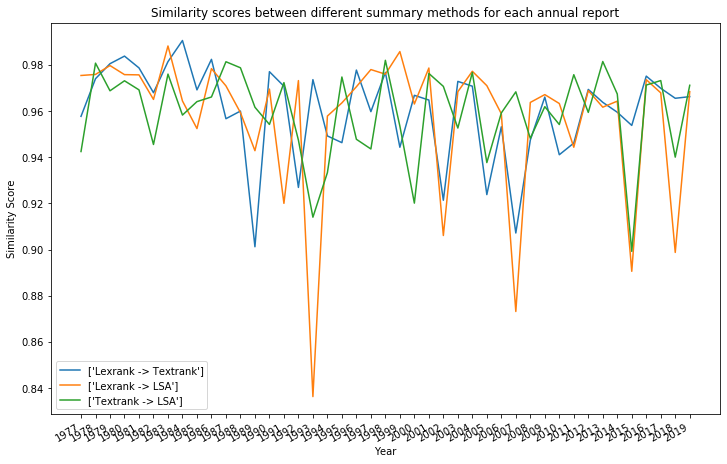

In [17]:
# If the graph does not appear, try running the cell again.

f, ax = plt.subplots(figsize=(12, 8))
plt.plot(similarity_ab)
plt.plot(similarity_ac)
plt.plot(similarity_bc)
plt.legend([['Lexrank -> Textrank'], ['Lexrank -> LSA'], ['Textrank -> LSA']])

ax.set_title(
    'Similarity scores between different summary methods for each annual report'
)
ax.set_xticks([x for x in range(43)])
ax.set_xticklabels([str(x) for x in range(1977, 2020)])
ax.set_ylabel('Similarity Score')
ax.set_xlabel('Year')

f.autofmt_xdate()

plt.show()

Creating the summaries and exporting them to a text file.

In [18]:
def write_summaries_to_file(new_summary_file, file_name):
    '''Writes the summaries created by create_summary to a file'''

    if os.path.isfile(f'../Summaries/{file_name}_summaries.txt') == False:
        for year, summary in enumerate(new_summary_file, 1977):
            paragraph = ' '.join(map(str, summary))
            with open(f'../Summaries/{file_name}_summaries.txt',
                      'a',
                      encoding='utf-8',
                      errors='ignore') as outfile:
                outfile.write(f'{year} : {paragraph}' + '\n' + '\n')

Use the function above to write the paragraphs of the yearly summaries to a file.

In [19]:
write_summaries_to_file(lexrank_summaries, "LexRank_Summaries")
write_summaries_to_file(textrank_summaries, "TextRank_Summaries")
write_summaries_to_file(lsa_summaries, "LSA_Summaries")

<h2 align='center'> Notebook 2, Part 3: Topic Modeling</h2> <br>

Adding several stop words that showed up in original topics. Pronouns in general are not helpful and ambiguous.

In [20]:
nlp = spacy.load('en_core_web_sm')

nlp.Defaults.stop_words |= {'berkshire', 'berkshires', 'billion', 'billions', 'million', 'millions', 'month',
                            'number', '_number' 'that', 'they', 'this', 'which', 'what', 'year', 'years'}
stop_words = nlp.Defaults.stop_words

Getting the letters post-Textacy cleaning 

In [21]:
annual_letters = dict()
for year in range(1977, 2020):
    file = f'../Letters/clean_letters/{year}_letter.txt'
    with open(file=file, encoding='utf-8', errors='ignore') as f:
        annual_letters[str(year)] = str(f.readlines())    

Cleaning the letters for Topic Modeling purposes. The "Date" labels take out things like "last year", which doesn't add value to the model. Cardinal and money take out digits that are hard on the model to analyze properly.

In [22]:
text_data = []
# Iterates through each article in the corpus.
for year in tqdm(annual_letters):
    # Passes that article through the pipeline and adds to a new list.
    textacy_letter = textacy_replace_remove(annual_letters[year])
    tokenized_letter = nlp(textacy_letter)
    entities = [str(ent).lower() for ent in tokenized_letter.ents if ent.label_ not in [
        'DATE', 'CARDINAL', 'MONEY']]
    no_digits = [re.sub(r'[^a-zA-Z\s]', '', ent) for ent in entities]
    strip_whitespace = [ent.strip() for ent in no_digits]
    potential_words = [
        chunk for chunk in strip_whitespace if len(chunk) > 3]
    potential_words = [
        topic for topic in potential_words if topic not in stop_words]
    text_data.append(potential_words)

Creating a dictionary and corpus from the text data.

In [23]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

Create a function to compute coherence score for model varying by number of topics.

In [24]:
def compute_coherence_model(corpus, dictionary, passes=100, min_topics=5, max_topics=25):
    """Computes a list of coherence scores for each number of topics given."""

    coherence_model_scores = []
    for n in tqdm(range(min_topics, max_topics)):
        model = gensim.models.ldamodel.LdaModel(
            corpus, id2word=dictionary, num_topics=n, passes=passes, per_word_topics=True)
        coherence_model_lda = CoherenceModel(
            model, texts=text_data, dictionary=dictionary, coherence='c_v')
        coherence_model_scores.append(coherence_model_lda.get_coherence())
    return(coherence_model_scores)

Applying above function to corpus to output score between 0 and 1 (higher -> more cohesive topics)

In [25]:
coherence_model_scores = compute_coherence_model(corpus=corpus, dictionary=dictionary)

Plotting the coherence scores for each number of topics in the topic model.

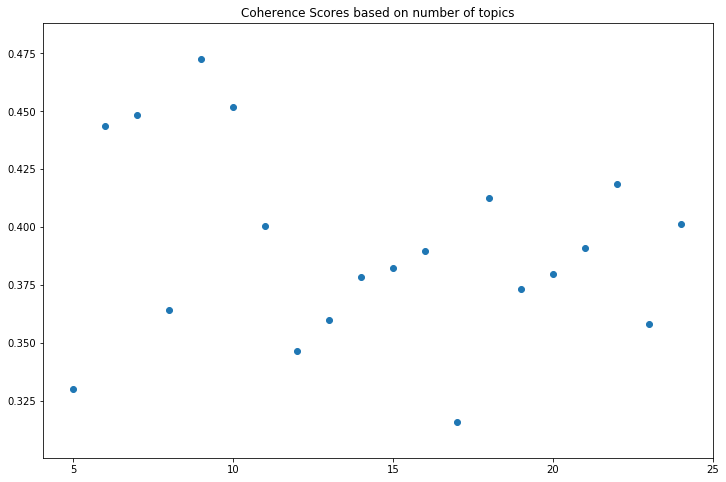

In [26]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 25)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics')
ax.set_xticks([5*x + 5 for x in range(5)])
plt.show()

Building an LDA model with the highest coherence score.

In [27]:
NUM_TOPICS = coherence_model_scores.index(max(coherence_model_scores)) + 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary,
                                           minimum_probability=.01,
                                           num_topics=NUM_TOPICS,
                                           passes=100,
                                           per_word_topics=True,
                                           )
ldamodel.save('ldamodel.model')

Plotting the topics. The X and Y axis are generated using Principal Component Analysis. The main things to look for are the size of the bubbles and which bubbles overlap (similar topics).

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds='mmds')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.036004  0.265055       1        1  21.995075
7      0.090313  0.084150       2        1  21.045326
3      0.243503 -0.047602       3        1  17.714863
4     -0.196029  0.040135       4        1  10.945708
5     -0.113234  0.136924       5        1   8.629186
6     -0.059500 -0.263464       6        1   7.290383
2     -0.033032  0.007540       7        1   6.461409
1      0.107138 -0.100527       8        1   5.102933
0     -0.075163 -0.122210       9        1   0.815115, topic_info=     Category        Freq                      Term       Total  loglift  \
0     Default  115.000000                  american  115.000000  30.0000   
2369  Default   58.000000                      bnsf   58.000000  29.0000   
325   Default   58.000000                  goodwill   58.000000  28.0000   
463   Default   62.000000              scott fetzer   62.000000  27.0000   
267   Default  512.000000                   charlie  512.000000  26.0000   
...       ...         ...                       ...         ...      ...   
254    Topic9    0.249364                tom murphy   13.133485   0.8456   
220    Topic9    0.249363           wesco financial    5.413341   1.7319   
183    Topic9    0.249363            charlie munger   16.493504   0.6178   
128    Topic9    0.249363  associated retail stores    5.422589   1.7302   
256    Topic9    0.249363          warren e buffett   18.987162   0.4770   

      logprob  
0     30.0000  
2369  29.0000  
325   28.0000  
463   27.0000  
267   26.0000  
...       ...  
254   -5.9189  
220   -5.9189  
183   -5.9189  
128   -5.9189  
256   -5.9189  

[660 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
1091      8  0.734924  a few personal items
2508      1  0.828173                 a ton
1092      8  0.873555                 abner
1204      8  0.734924            about noon
1768      7  0.708122     about ten seconds
...     ...       ...                   ...
164       4  0.026236               yearend
164       5  0.104946               yearend
164       6  0.052473               yearend
164       7  0.026236               yearend
164       8  0.052473               yearend

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 4, 5, 6, 7, 3, 2, 1])

To compare, I am going to experiment with Mallet LDA. See http://mallet.cs.umass.edu/topics.php for details. For the rest of the notebook to work, download the Mallet Package from http://mallet.cs.umass.edu/download.php and change the mallet path to the right location on your drive. Relative references don't work for this (reason for jump from 28 to 43 in cells run).

In [43]:
## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'C:/Users/Tom/Documents/Berkshire/Berkshire_Final_Report/mallet-2.0.8'})
    
## Setup mallet path change it according to your drive
mallet_path = 'C:/Users/Tom/Documents/Berkshire/Berkshire_Final_Report/mallet-2.0.8/bin/mallet'


Generating Coherence model scores.

In [44]:
coherence_model_scores = []
for n in tqdm(range(5, 25)):
    model=gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n, id2word=dictionary)
    coherence_model_mallet = CoherenceModel(model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_model_scores.append(coherence_model_mallet.get_coherence())

Plotting Coherence Scores based on number of topics.

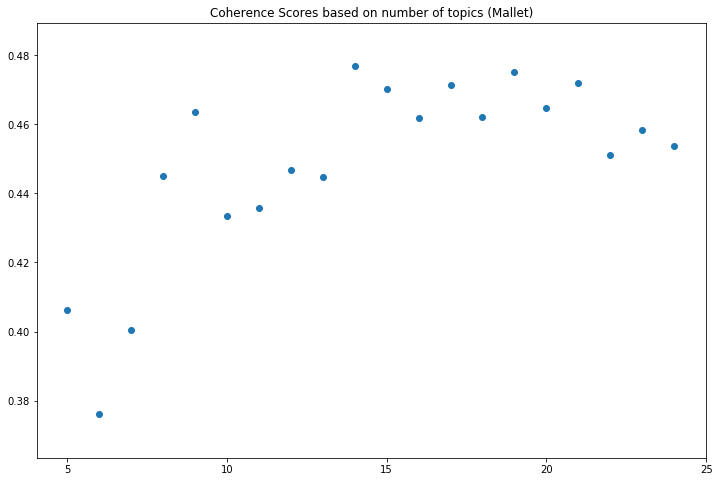

In [45]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 25)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics (Mallet)')
ax.set_xticks([5*x + 5 for x in range(5)])
plt.show()

Visualizing the Mallet LDA topic model with 9 topics.

In [48]:
NUM_TOPICS = 9 # After testing, this provided the "best" topics
model=gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
ldamodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
ldamodel.save('mallet.model')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds='mmds')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.446784 -0.003484       1        1  19.926644
0      0.098232  0.423006       2        1  13.697925
2     -0.118542  0.094645       3        1  12.335526
8     -0.247791 -0.301524       4        1  11.785703
3      0.009121 -0.236613       5        1  10.581305
4     -0.291824  0.295970       6        1   9.481005
7      0.244381 -0.365236       7        1   9.018387
5      0.413479 -0.132300       8        1   7.193995
1      0.339728  0.225537       9        1   5.979509, topic_info=     Category        Freq     Term       Total  loglift  logprob
267   Default  770.000000  charlie  770.000000  30.0000  30.0000
2022  Default  144.000000    scott  144.000000  29.0000  29.0000
233   Default  219.000000     gaap  219.000000  28.0000  28.0000
857   Default  318.000000  company  318.000000  27.0000  27.0000
136   Default  176.000000    geico  176.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
136    Topic9   15.804610    geico  176.627055   0.4031  -3.7626
86     Topic9    9.296829    frank   51.834000   1.0985  -4.2932
201    Topic9    8.367146   kansas   47.716683   1.0759  -4.3986
171    Topic9    6.507781  bancorp   20.847666   1.6526  -4.6499
362    Topic9    6.507781     bill   80.022736   0.3075  -4.6499

[620 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2620      1  1.008598            abel
1092      5  0.994942           abner
1585      2  1.019189            acme
2239      7  0.992807            adam
1868      7  0.992807  administration
...     ...       ...             ...
221       9  1.075636       yardstick
164       1  0.635215         yearend
164       3  0.360918         yearend
1969      2  0.953627       yorkshire
840       6  0.819252      zerocoupon

[658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 9, 4, 5, 8, 6, 2])

For each topic, print the top 10 words and their weights.

In [49]:
# later on, load trained model from file
model = gensim.models.LdaModel.load('mallet.model')

pprint.pprint(model.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=True))

[(0,
  '0.064*"netjets" + 0.043*"company" + 0.031*"walter" + 0.029*"american" + '
  '0.028*"john" + 0.026*"total" + 0.025*"shaw" + 0.023*"clayton" + '
  '0.020*"midamerican" + 0.019*"midamericans"'),
 (1,
  '0.112*"company" + 0.063*"wesco" + 0.060*"corporation" + 0.049*"jack" + '
  '0.049*"hathaway" + 0.042*"insurance" + 0.038*"illinois" + 0.037*"bank" + '
  '0.034*"phil" + 0.033*"california"'),
 (2,
  '0.134*"charlie" + 0.072*"company" + 0.061*"geico" + 0.042*"tony" + '
  '0.031*"bill" + 0.025*"omaha" + 0.024*"flightsafety" + 0.021*"hours" + '
  '0.018*"freddie" + 0.018*"willey"'),
 (3,
  '0.069*"gillette" + 0.052*"borsheim" + 0.050*"company" + 0.049*"wells" + '
  '0.048*"charlie" + 0.042*"usair" + 0.040*"salomon" + 0.038*"california" + '
  '0.037*"coke" + 0.028*"earnings"'),
 (4,
  '0.164*"charlie" + 0.058*"news" + 0.048*"board" + 0.045*"buffalo" + '
  '0.035*"chuck" + 0.033*"mike" + 0.032*"corporation" + 0.029*"buffett" + '
  '0.029*"salomon" + 0.028*"stan"'),
 (5,
  '0.177*"scott" 